In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def cv_show(title, img):
    cv2.imshow(title, img)
    cv2.waitKey(0)                  ## Press any key to interrupt
    cv2.destroyAllWindows()

In [2]:
K = np.loadtxt('./Glyp/K.txt').astype('float32')
K

array([[3.1174741e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174741e+03, 9.8476837e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

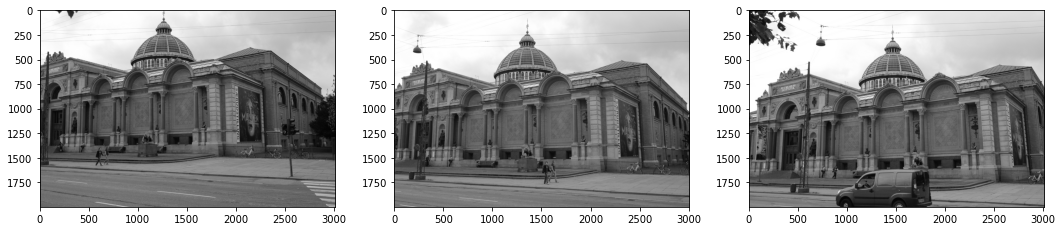

In [3]:
im1 = cv2.imread('./Glyp/sequence/000001.png')
gray1 = cv2.cvtColor(im1.copy(), cv2.COLOR_BGR2GRAY)

im2 = cv2.imread('./Glyp/sequence/000002.png')
gray2 = cv2.cvtColor(im2.copy(), cv2.COLOR_BGR2GRAY)

im3 = cv2.imread('./Glyp/sequence/000003.png')
gray3 = cv2.cvtColor(im3.copy(), cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(im1)
plt.subplot(1,3,2)
plt.imshow(im2)
plt.subplot(1,3,3)
plt.imshow(im3)

# Ex 11.1

In [4]:
sift = cv2.xfeatures2d.SIFT_create()
matcher = cv2.BFMatcher(crossCheck=True)

kp1, des1 = sift.detectAndCompute(gray1.copy(), None)
kp2, des2 = sift.detectAndCompute(gray2.copy(), None)
kp3, des3 = sift.detectAndCompute(gray3.copy(), None)

kp1 = np.array([k.pt for k in kp1]).astype('float32')
kp2 = np.array([k.pt for k in kp2]).astype('float32')
kp3 = np.array([k.pt for k in kp3]).astype('float32')


matches12 = matcher.match(des1, des2)
matches_12 = np.array([(m.queryIdx, m.trainIdx) for m in matches12])
matches23 = matcher.match(des2, des3)
matches_23 = np.array([(m.queryIdx, m.trainIdx) for m in matches23])

# Ex 11.2

In [5]:
E_12, mask_Ess_12 = cv2.findEssentialMat(kp2[matches_12[:,1]], kp1[matches_12[:,0]], K, method=cv2.RANSAC, prob=0.999, threshold=0.1)
#E_23, _ = cv2.findEssentialMat(kp2[matches_23[:,0]], kp3[matches_23[:,1]], K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

inliers_num, R21, Tvec_21, mask_12 = cv2.recoverPose(E_12, kp2[matches_12[:, 1]], kp1[matches_12[:, 0]], mask=mask_Ess_12)
# where R, t is the rotation and translation matrix from camera2(kp2) to camera1


In [6]:
np.where(mask_12.flatten()==1)[0]

array([   9,   13,   18, ..., 8694, 8729, 8732])

In [7]:
matches_12

array([[    0, 17933],
       [    9,   875],
       [   11,  3495],
       ...,
       [20702,    50],
       [20705,  1925],
       [20722,  3665]])

In [8]:
R21

array([[ 0.99989643,  0.0098175 ,  0.01052329],
       [-0.00931015,  0.99884101, -0.04722246],
       [-0.0109747 ,  0.04711959,  0.99882896]])

In [9]:
Tvec_21

array([[ 0.91888612],
       [-0.05620118],
       [-0.39049933]])

In [10]:
-R21 @ Tvec_21

array([[-0.91412986],
       [ 0.04625068],
       [ 0.40277472]])

In [11]:
## Remove outliers, only keep inliers
matches_12_inlier = matches_12[np.where(mask_12.flatten() == 1)[0]]

In [12]:
matches_12_inlier.shape

(2257, 2)

# Ex 11.3

In [13]:
_, idx12, idx23 = np.intersect1d(matches_12_inlier[:,1], matches_23[:,0], return_indices=True)

points1 = kp1[matches_12_inlier[idx12, 0]]

points2 = kp2[matches_12_inlier[idx12, 1]] 

points3 = kp3[matches_23[idx23, 1]]

In [14]:
points3.shape

(1451, 2)

In [15]:
idx23

array([ 428,  430,  431, ..., 9074, 9080, 9181])

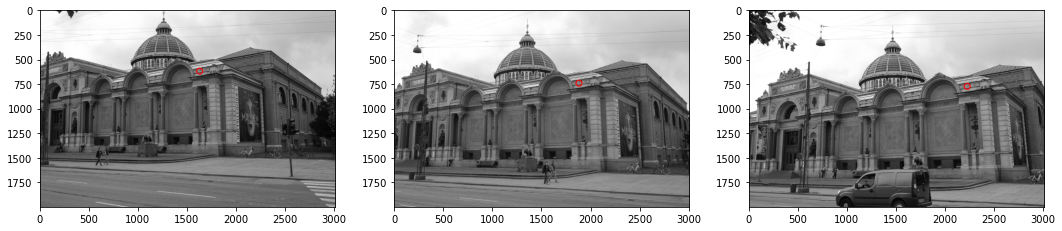

In [16]:
## Verify 
sample = 1200
im1_ver = cv2.circle(im1.copy(), (int(points1[sample][0]), int(points1[sample][1])), 30, (255, 0, 0), 10)
im2_ver = cv2.circle(im2.copy(), (int(points2[sample][0]), int(points2[sample][1])), 30, (255, 0, 0), 10)
im3_ver = cv2.circle(im3.copy(), (int(points3[sample][0]), int(points3[sample][1])), 30, (255, 0, 0), 10)
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(im1_ver)
plt.subplot(1,3,2)
plt.imshow(im2_ver)
plt.subplot(1,3,3)
plt.imshow(im3_ver)


# Ex 11.4

In [17]:
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R21, Tvec_21))

In [18]:
## Triangulation
features3D = cv2.triangulatePoints(P1, P2, points1.T, points2.T)
features3D = (features3D[:3]/features3D[-1]).T

In [74]:
## PnP
_, rvec, tvec, inliers= cv2.solvePnPRansac(features3D, points3, K, distCoeffs=np.zeros(5))
# Here, R and T is from Camera to World, if we need the orientation and position of Cam, We need the R from world to Cam

In [85]:
R_C2W, _ = cv2.Rodrigues(rvec)
R_W2C = R_C2W.T
T_W2C = - R_C2W.T @ tvec
print('Number of inliers:', inliers.shape[0])
print('Position:\n{}'.format(T_W2C))
print('Orientation:\n{}'.format(R_W2C))

Number of inliers: 729
Position:
[[-1.97657039]
 [ 0.12264429]
 [ 1.62974914]]
Orientation:
[[ 0.99928617 -0.00683682 -0.03715373]
 [ 0.00599507  0.99972389 -0.02272013]
 [ 0.0372988   0.02248118  0.99905125]]


In [86]:
inliers.shape

(729, 1)

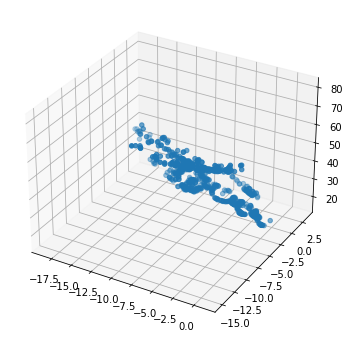

In [87]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(features3D[inliers.flatten()][:,0], features3D[inliers.flatten()][:,1], features3D[inliers.flatten()][:,2])

# Ex 11.5

In [32]:
imgList = []
path = os.listdir('./Glyp/sequence/')
for file in path:
    if file.endswith('.png'):
        imgList.append(os.path.join('./Glyp/sequence', file))
imgList = sorted(imgList) 

In [33]:
imgList

['./Glyp/sequence/000001.png',
 './Glyp/sequence/000002.png',
 './Glyp/sequence/000003.png',
 './Glyp/sequence/000004.png',
 './Glyp/sequence/000005.png',
 './Glyp/sequence/000006.png',
 './Glyp/sequence/000007.png',
 './Glyp/sequence/000008.png',
 './Glyp/sequence/000009.png',
 './Glyp/sequence/000010.png',
 './Glyp/sequence/000011.png',
 './Glyp/sequence/000012.png',
 './Glyp/sequence/000013.png',
 './Glyp/sequence/000014.png',
 './Glyp/sequence/000015.png',
 './Glyp/sequence/000016.png',
 './Glyp/sequence/000017.png',
 './Glyp/sequence/000018.png',
 './Glyp/sequence/000019.png',
 './Glyp/sequence/000020.png']

In [34]:
K = np.loadtxt('./Glyp/K.txt').astype('float32')
sift = cv2.xfeatures2d.SIFT_create()
#matcher = cv2.BFMatcher(crossCheck=True)
matcher = cv2.BFMatcher()

Position = [np.array([0, 0, 0])]
Orientation = [np.eye(3)]

###### Read initial three images ######
im1 = cv2.imread(imgList[0])
gray1 = cv2.cvtColor(im1.copy(), cv2.COLOR_BGR2GRAY)
im2 = cv2.imread(imgList[1])
gray2 = cv2.cvtColor(im2.copy(), cv2.COLOR_BGR2GRAY)
im3 = cv2.imread(imgList[2])
gray3 = cv2.cvtColor(im3.copy(), cv2.COLOR_BGR2GRAY)

###### Features Extraction and Matching ######
kp1, des1 = sift.detectAndCompute(gray1.copy(), None)
kp2, des2 = sift.detectAndCompute(gray2.copy(), None)
kp3, des3 = sift.detectAndCompute(gray3.copy(), None)

kp1 = np.array([k.pt for k in kp1]).astype('float32')
kp2 = np.array([k.pt for k in kp2]).astype('float32')
kp3 = np.array([k.pt for k in kp3]).astype('float32')
#matches_12 = matcher.match(des1, des2)
matches_12 = matcher.knnMatch(des1, des2, k=2)
good = []
for i,j in matches_12:
    if i.distance / j.distance < 0.7:
        good.append(i)
good = sorted(good, key = lambda x:x.distance)

#matches_12 = np.array([(m.queryIdx, m.trainIdx) for m in matches_12])
matches_12 = np.array([(m.queryIdx, m.trainIdx) for m in good])


#matches_23 = matcher.match(des2, des3)
matches_23 = matcher.knnMatch(des2, des3, k=2)
good = []
for i,j in matches_23:
    if i.distance / j.distance < 0.7:
        good.append(i)
good = sorted(good, key = lambda x:x.distance)
#matches_23 = np.array([(m.queryIdx, m.trainIdx) for m in matches_23])
matches_23 = np.array([(m.queryIdx, m.trainIdx) for m in good])

###### Get the pose of 2nd Camera by Essential matrix ######
E_12, mask_Ess_12 = cv2.findEssentialMat(kp2[matches_12[:,1]], kp1[matches_12[:,0]], K, method=cv2.RANSAC, prob=0.999, threshold=0.1)
inliers_num, R21, Tvec_21, mask_12 = cv2.recoverPose(E_12, kp2[matches_12[:, 1]], kp1[matches_12[:, 0]], mask=mask_Ess_12)
matches_12_inlier = matches_12[np.where(mask_12.flatten() == 1)[0]]

Position.append(-R21.T@Tvec_21)
Orientation.append(R21.T)

###### Find the same feature points in three Images ######
_, idx12, idx23 = np.intersect1d(matches_12_inlier[:,1], matches_23[:,0], return_indices=True)
points1 = kp1[matches_12_inlier[idx12, 0]]
points2 = kp2[matches_12_inlier[idx12, 1]] 
points3 = kp3[matches_23[idx23, 1]]

###### Triangulation ######
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R21, Tvec_21))
features3D = cv2.triangulatePoints(P1, P2, points1.T, points2.T)
features3D = (features3D[:3]/features3D[-1]).T

###### PnP to get the Pose and Position of 3rd Cam ######
_, rvec, tvec, inliers= cv2.solvePnPRansac(features3D, points3, K, distCoeffs=np.zeros(5))
R_C2W, _ = cv2.Rodrigues(rvec)
R_W2C = R_C2W.T
T_W2C = - R_C2W.T @ tvec



Position.append(T_W2C)
Orientation.append(R_W2C)

In [35]:
T_W2C

array([[-1.99922969],
       [ 0.12492603],
       [ 1.68657157]])

In [36]:
kp_prepre = kp2
R_prepre = R21
T_prepre = Tvec_21

pre_img = gray3.copy()
kp_pre = kp3
des_pre = des3
matches_pre = matches_23
R_pre = R_C2W
T_pre = tvec
for i in range(3, len(imgList)):
    cur_img = cv2.imread(imgList[i], 0)
    kp_cur, des_cur = sift.detectAndCompute(cur_img.copy(), None)
    kp_cur = np.array([k.pt for k in kp_cur]).astype('float32')
    #matches_cur = matcher.match(des_pre, des_cur)
    matches_cur = matcher.knnMatch(des_pre, des_cur, k=2)
    good = []
    for a,b in matches_cur:
        if a.distance / b.distance < 0.7:
            good.append(a)
    good = sorted(good, key = lambda x:x.distance)
    #matches_cur = np.array([(m.queryIdx, m.trainIdx) for m in matches_cur])
    matches_cur = np.array([(m.queryIdx, m.trainIdx) for m in good])
    
    ###### Get same features in three Images ######
    _, idx_prepre, idx_cur = np.intersect1d(matches_pre[:,1], matches_cur[:,0], return_indices=True)
    points_prepre = kp_prepre[matches_pre[idx_prepre, 0]]
    points_pre = kp_pre[matches_pre[idx_prepre, 1]]
    points_cur = kp_cur[matches_cur[idx_cur, 1]]
    
    ###### Triangulation ######
    P_prepre = K @ np.hstack((R_prepre, T_prepre))
    P_pre = K @ np.hstack((R_pre, T_pre))
    features3D = cv2.triangulatePoints(P_prepre, P_pre, points_prepre.T, points_pre.T)
    features3D = (features3D[:3]/features3D[-1]).T
    
    ###### Get new Pose and Position ######
    _, rvec, tvec, inliers= cv2.solvePnPRansac(features3D, points_cur, K, distCoeffs=np.zeros(5))
    R_C2W, _ = cv2.Rodrigues(rvec)
    R_W2C = R_C2W.T
    T_W2C = - R_C2W.T @ tvec
    Position.append(T_W2C)
    Orientation.append(R_W2C)
    
    ###### Update ######
    kp_prepre = kp_pre
    R_prepre = R_pre
    T_prepre = T_pre

    pre_img = cur_img.copy()
    kp_pre = kp_cur
    des_pre = des_cur
    matches_pre = matches_cur
    R_pre = R_C2W
    T_pre = tvec
    print(inliers.shape)
    print('Process:', i/len(imgList))

(379, 1)
Process: 0.15
(1720, 1)
Process: 0.2
(1758, 1)
Process: 0.25
(1401, 1)
Process: 0.3
(1618, 1)
Process: 0.35
(1159, 1)
Process: 0.4
(824, 1)
Process: 0.45
(776, 1)
Process: 0.5
(870, 1)
Process: 0.55
(866, 1)
Process: 0.6
(502, 1)
Process: 0.65
(145, 1)
Process: 0.7
(214, 1)
Process: 0.75
(266, 1)
Process: 0.8
(163, 1)
Process: 0.85
(88, 1)
Process: 0.9
(52, 1)
Process: 0.95


In [30]:
Position

[array([0, 0, 0]),
 array([[-0.92470012],
        [ 0.06520589],
        [ 0.37507051]]),
 array([[-1.99922969],
        [ 0.12492603],
        [ 1.68657157]]),
 array([[-5.82004848],
        [ 0.38285382],
        [ 4.4418808 ]]),
 array([[-14.43196849],
        [ -0.05359282],
        [ 10.40557601]]),
 array([[-37.38029823],
        [  2.67475884],
        [ 22.42975479]]),
 array([[ 163.29626587],
        [-154.1250906 ],
        [-133.46198543]]),
 array([[  17.69462586],
        [-350.5143685 ],
        [-192.02592869]]),
 array([[-305.55114025],
        [-359.68201389],
        [-308.72046206]]),
 array([[ -59.20411302],
        [-902.10452343],
        [-225.66217936]]),
 array([[ 577.39754004],
        [-766.47737957],
        [-842.46954847]]),
 array([[ 1441.88024449],
        [-2163.42745581],
        [  323.74119117]]),
 array([[ -961.57555792],
        [ -660.23854302],
        [-2111.58244796]]),
 array([[ -147.28526999],
        [ -700.81378842],
        [-2559.00627756

/Users/lijiahao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/Users/lijiahao/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array, copy=False, subok=subok)
/Users/lijiahao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-o

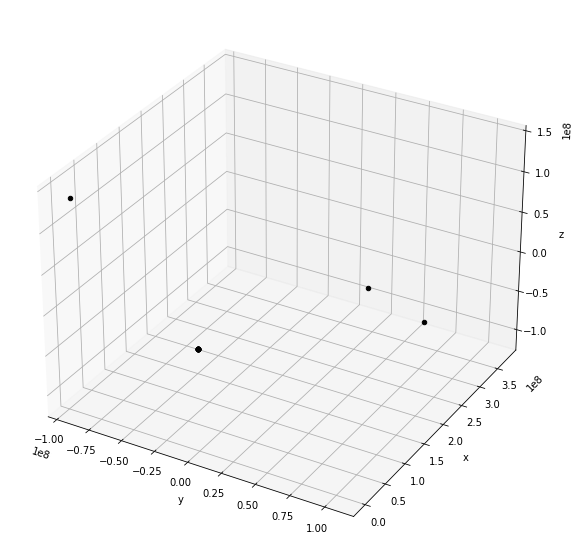

In [31]:
fig = plt.figure(1, figsize=(10,10))
ax = plt.axes(projection='3d')
colors = ['r', 'g', 'b']

ax.set_xlabel('y')
ax.set_ylabel('x')
ax.set_zlabel('z')
for r, t in zip(Orientation[2:], Position[2:]):
    ax.scatter(t[1], t[0], t[2], color = 'k')
    for i in range(3):
        o = r[:, i]
        d = o + [t[1][0], t[0][0], t[2][0]]
        ax.plot([t[1], d[0]], [t[0], d[1]], [t[2], d[2]], color=colors[i])
plt.show()

# Ex 11.6

In [142]:
def Same_features(imgList, matches_12_inlier, sift, matcher):
    Match = {}
    Index = {}
    KP = {}
    pre_img = cv2.imread(imgList[1], 0)
    kp_pre, des_pre = sift.detectAndCompute(pre_img.copy(), None)
    kp_pre = np.array([k.pt for k in kp_pre]).astype('float32')
    matches_pre = matches_12_inlier
    for i in range(2, len(imgList)-7):

        cur_img = cv2.imread(imgList[i], 0)
        kp_cur, des_cur = sift.detectAndCompute(cur_img.copy(), None)
        kp_cur = np.array([k.pt for k in kp_cur]).astype('float32')
        #matches = matcher.match(des_pre, des_cur)
        matches = matcher.knnMatch(des_pre, des_cur, k=2)
        good = []
        for a,b in matches:
            if a.distance / b.distance < 0.7:
                good.append(a)
        good = sorted(good, key = lambda x:x.distance)
        #matches = np.array([(m.queryIdx, m.trainIdx) for m in matches])
        matches = np.array([(m.queryIdx, m.trainIdx) for m in good])
        _, idx_prepre, idx_cur = np.intersect1d(matches_pre[:,1], matches[:,0], return_indices=True)
        matches = matches[idx_cur,:]
        Match[str(i)] = matches
        Index[str(i)] = (idx_prepre, idx_cur)
        KP[str(i)] = kp_cur
        print(idx_cur.shape)
        
        pre_img = cur_img
        kp_pre = kp_cur
        des_pre = des_cur
        matches_pre = matches
    
        
    return Match, KP
        

        

In [143]:
## Get same features of first three points
K = np.loadtxt('./Glyp/K.txt').astype('float32')
sift = cv2.xfeatures2d.SIFT_create()
#matcher = cv2.BFMatcher(crossCheck=True)
matcher = cv2.BFMatcher()

Position = [np.array([0, 0, 0])]
Orientation = [np.eye(3)]

###### Read initial three images ######
im1 = cv2.imread(imgList[0])
gray1 = cv2.cvtColor(im1.copy(), cv2.COLOR_BGR2GRAY)
im2 = cv2.imread(imgList[1])
gray2 = cv2.cvtColor(im2.copy(), cv2.COLOR_BGR2GRAY)

###### Features Extraction and Matching ######
kp1, des1 = sift.detectAndCompute(gray1.copy(), None)
kp2, des2 = sift.detectAndCompute(gray2.copy(), None)

kp1 = np.array([k.pt for k in kp1]).astype('float32')
kp2 = np.array([k.pt for k in kp2]).astype('float32')

#matches_12 = matcher.match(des1, des2)
matches_12 = matcher.knnMatch(des1, des2, k=2)
good = []
for a,b in matches_12:
    if a.distance / b.distance < 0.7:
        good.append(a)
good = sorted(good, key = lambda x:x.distance)
#matches_12 = np.array([(m.queryIdx, m.trainIdx) for m in matches_12])
matches_12 = np.array([(m.queryIdx, m.trainIdx) for m in good])

###### Get the pose of 2nd Camera by Essential matrix ######
E_12, mask_Ess_12 = cv2.findEssentialMat(kp2[matches_12[:,1]], kp1[matches_12[:,0]], K, method=cv2.RANSAC, prob=0.999, threshold=0.1)
inliers_num, R21, Tvec_21, mask_12 = cv2.recoverPose(E_12, kp2[matches_12[:, 1]], kp1[matches_12[:, 0]], mask=mask_Ess_12)
matches_12_inlier = matches_12[np.where(mask_12.flatten() == 1)[0]]
Position.append(-R21.T@Tvec_21)
Orientation.append(R21.T)

Match, KP = Same_features(imgList, matches_12_inlier, sift, matcher)



(845,)
(401,)
(248,)
(147,)
(83,)
(57,)
(35,)
(23,)
(16,)
(10,)
(8,)


In [144]:
for i in range(0, len(Match)-1):
    _, idx_pre, idx_cur = np.intersect1d(Match[str(len(Match) + 1 - (i+1))][:,1], Match[str(len(Match) + 1 - i)][:,0], return_indices=True)
    Match[str(len(Match)+1-i)] = Match[str(len(Match)+1-i)][idx_cur]
    Match[str(len(Match)+1-(i+1))] = Match[str(len(Match)+1-(i+1))][idx_pre]
    KP[str(len(Match)+1-i)] = KP[str(len(Match)+1-i)][Match[str(len(Match)+1-i)][:,1]] 
    #KP[str(len(imgList)-4-2-1-(i+1))] = KP[str(len(imgList)-4-2-1-(i+1))][idx_pre]


In [145]:
 _, idx_0, idx_2 = np.intersect1d(matches_12_inlier[:,1], Match['2'][:,0], return_indices=True)
KP['2'] = KP['2'][idx_2]
KP['1'] = kp2[matches_12_inlier[idx_0, 1]]
KP['0'] = kp1[matches_12_inlier[idx_0, 0]]

In [146]:
KP

{'2': array([[   2.8203778,  103.37733  ],
        [   2.8921561, 1207.7703   ],
        [   2.965102 , 1056.6033   ],
        [   3.0481112, 1619.3461   ],
        [   3.266492 , 1240.3097   ],
        [   3.266492 , 1240.3097   ],
        [   3.350019 , 1840.3163   ],
        [   3.3865676, 1219.2166   ]], dtype=float32),
 '3': array([[140.20522, 737.3764 ],
        [308.1794 , 699.43994],
        [327.30438, 715.19086],
        [424.7908 , 877.9761 ],
        [428.80145, 719.56744],
        [454.64374, 971.05206],
        [467.05304, 944.748  ],
        [600.3027 , 910.83636]], dtype=float32),
 '4': array([[298.65805, 628.8073 ],
        [484.74365, 593.17334],
        [505.915  , 609.9102 ],
        [613.99084, 783.1972 ],
        [618.0258 , 617.34393],
        [646.0986 , 881.43964],
        [659.73773, 854.4622 ],
        [806.92786, 821.35004]], dtype=float32),
 '5': array([[ 764.0463 ,  686.2075 ],
        [ 956.0891 ,  644.7814 ],
        [ 979.0315 ,  660.91064],
        [11

In [ ]:
## Verify 

i1 = 5
i2 = 6
i3 = 7

j = 2

im1 = cv2.imread(imgList[i1+1])
im1 = cv2.imread(imgList[i2+1])
im1 = cv2.imread(imgList[i3+1])

im1_ver = cv2.circle(im1.copy(), (int(KP[str(i1)][j][0]), int(KP[str(i1)][j][1])), 30, (255, 0, 0), 10)
im2_ver = cv2.circle(im2.copy(), (int(KP[str(i2)][j][0]), int(KP[str(i2)][j][1])), 30, (255, 0, 0), 10)
im3_ver = cv2.circle(im3.copy(), (int(KP[str(i3)][j][0]), int(KP[str(i3)][j][1])), 30, (255, 0, 0), 10)
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(im1_ver)
plt.subplot(1,3,2)
plt.imshow(im2_ver)
plt.subplot(1,3,3)
plt.imshow(im3_ver)

